In [18]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from pathlib import Path
from segmentflow import segment, view
from skimage import exposure, filters, morphology
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook tests different morphologic operations on a manual semantic
segmentation on an SEM back-scattered electron (BSE) image of
IDOX-Estane collected by Nate Peterson at Colorado School of Mines.

(481, 555)
(481, 555)


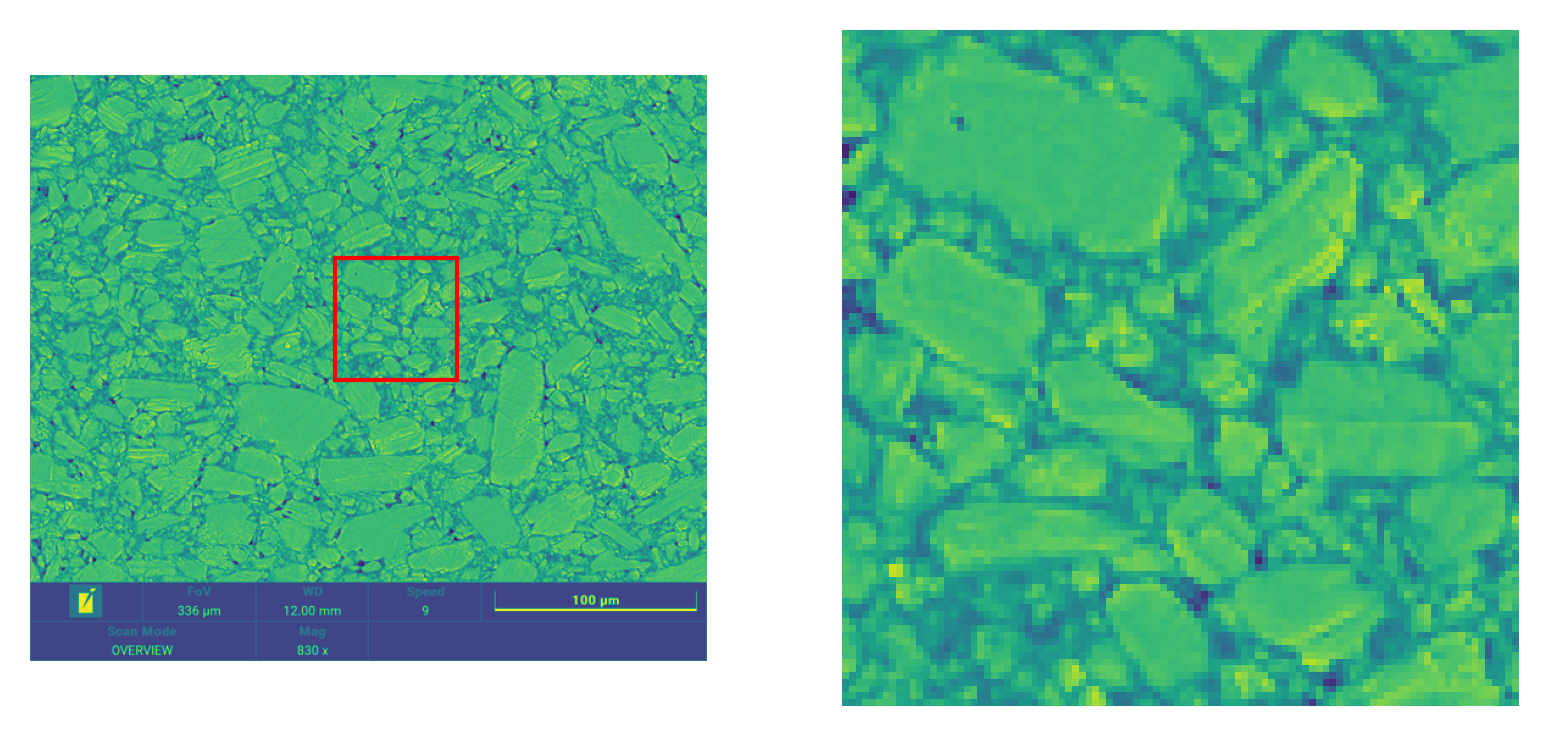

In [4]:
img_dir_path = Path('../data/sem_idox_estane2.tif')
img = iio.imread(img_dir_path)
print(img.shape)
# img = img[:400, :]
print(img.shape)
fig, axes = plt.subplots(1, 2, dpi=300)
axes[0].imshow(img, vmin=img.min(), vmax=img.max())
row_crop = [150, 250]
col_crop = [250, 350]
rect = patches.Rectangle(
    (col_crop[0], row_crop[0]),
    col_crop[1]-col_crop[0], row_crop[1]-row_crop[0],
    linewidth=1, edgecolor='r', facecolor='none')
axes[0].add_patch(rect)
img_crop = img[row_crop[0]:row_crop[1], col_crop[0]:col_crop[1]]
axes[1].imshow(
    img_crop, vmin=img.min(), vmax=img.max())
for a in axes:
    a.set_axis_off()

## Multi-Otsu Threshold

In [ ]:
thresh_vals = segment.threshold_multi_otsu(img_crop, nclasses=3)
thresh_vals

Generating histogram...


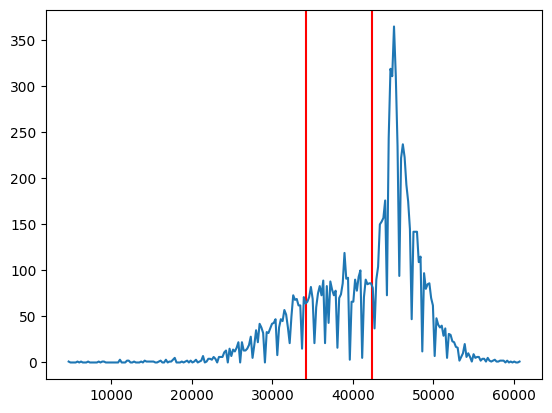

In [ ]:
fig, ax = view.histogram(img_crop, mark_values=list(thresh_vals))

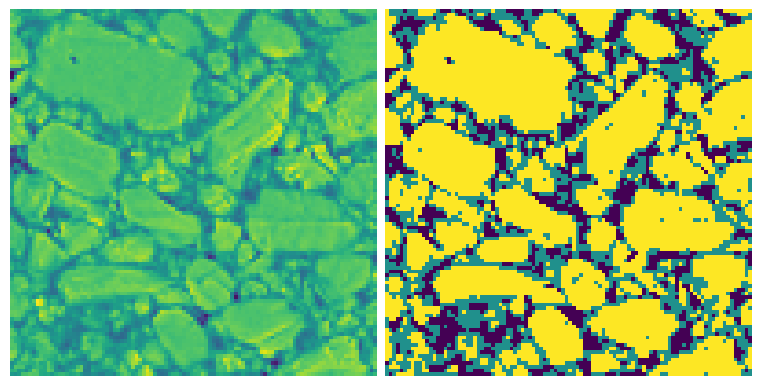

In [ ]:
img_sem_mo = segment.isolate_classes(img_crop, list(thresh_vals), intensity_step=1)
fig, ax = view.images([img_crop, img_sem_mo])

In [ ]:
img_labeled = img_sem_mo
n_pixels = img_labeled.shape[0] * img_labeled.shape[1]
n_void = np.count_nonzero(img_labeled == 0)
n_binder = np.count_nonzero(img_labeled == 1)
n_crystals = np.count_nonzero(img_labeled == 2)
print('--> Crystal area fraction:', n_crystals / n_pixels)
print(
    '--> Crystal area fraction (void corrected):',
    n_crystals / (n_pixels - n_void))

--> Crystal area fraction: 0.5793
--> Crystal area fraction (void corrected): 0.688495364868077


## Manual threshold

Generating histogram...
--> Void area fraction: 0.0077
--> Crystal area fraction: 0.8478
--> Crystal area fraction (void corrected): 0.8543787161140785


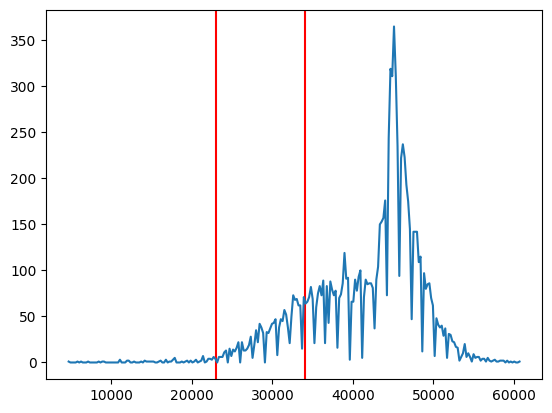

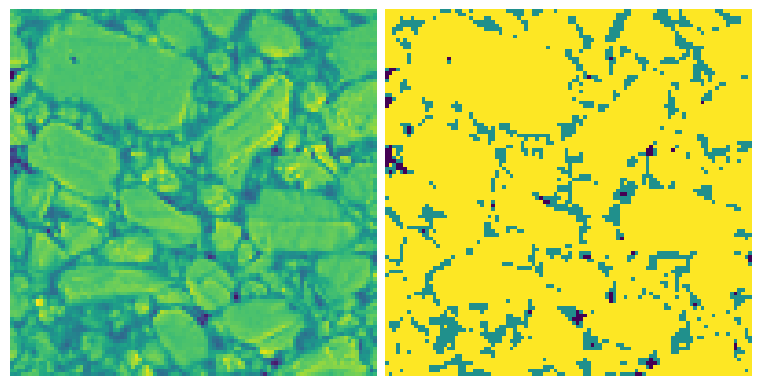

In [25]:
thresh_vals_man = [23000, 34000]
fig, ax = view.histogram(img_crop, mark_values=thresh_vals_man)
img_sem_man = segment.isolate_classes(img_crop, thresh_vals_man, intensity_step=1)
fig, ax = view.images([img_crop, img_sem_man])
img_labeled = img_sem_man
n_pixels = img_labeled.shape[0] * img_labeled.shape[1]
n_void = np.count_nonzero(img_labeled == 0)
n_binder = np.count_nonzero(img_labeled == 1)
n_crystals = np.count_nonzero(img_labeled == 2)
print('--> Void area fraction:', n_void / n_pixels)
print('--> Crystal area fraction:', n_crystals / n_pixels)
print(
    '--> Crystal area fraction (void corrected):',
    n_crystals / (n_pixels - n_void))

## Morphologic Operations

### Erosion/Dilation

--> Void area fraction: 0.1729
--> Crystal area fraction: 0.0
--> Crystal area fraction (void corrected): 0.0


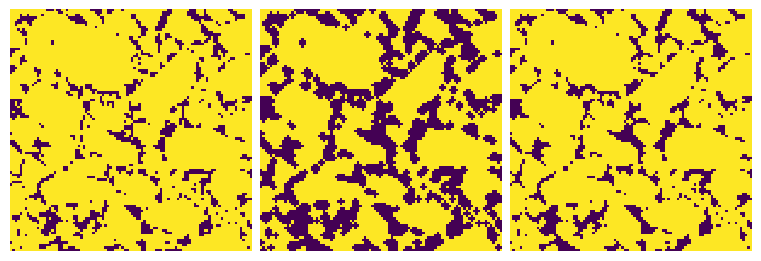

In [28]:
img_bin = img_sem_man.copy() == 2
img_bin_ero = morphology.binary_erosion(img_bin)
img_bin_ero_dil = morphology.binary_dilation(img_bin_ero)
fig, ax = view.images([img_bin, img_bin_ero, img_bin_ero_dil])
img_labeled = img_bin_ero_dil
n_pixels = img_labeled.shape[0] * img_labeled.shape[1]
n_crystals = np.count_nonzero(img_labeled == 2)
print('--> Void area fraction:', n_void / n_pixels)
print('--> Crystal area fraction:', n_crystals / n_pixels)
print(
    '--> Crystal area fraction (void corrected):',
    n_crystals / (n_pixels - n_void))

### Median filter

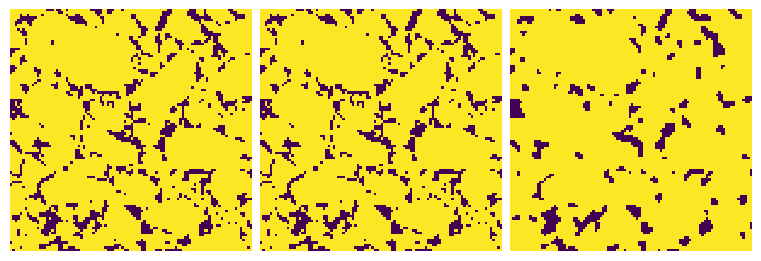

In [27]:
img_bin_med = filters.median(img_bin)
fig, ax = view.images([img_bin, img_bin, img_bin_med])

## Instance segmentation

In [13]:
fig, axes = view.images(
    [img_crop, img_semantic, img_pre, img_pre_semantic],
    imgs_per_row=2, dpi=100)

NameError: name 'img_semantic' is not defined

## Test instance segmentation

Segmenting images...
--> Segmentation complete. 77 particle(s) segmented.
Segmenting images...
--> Segmentation complete. 58 particle(s) segmented.


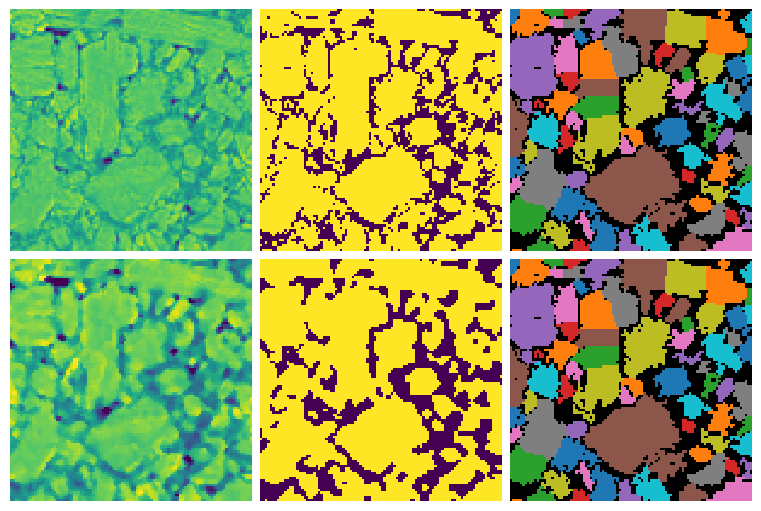

In [7]:
img_labeled_4msd = segment.watershed_segment(img_semantic, min_peak_distance=4)
img_labeled_color_4msd = view.color_labels(img_labeled_4msd, return_image=True)
img_pre_labeled_4msd = segment.watershed_segment(
    img_pre_semantic, min_peak_distance=4)
img_pre_labeled_color_4msd = view.color_labels(
    img_labeled_4msd, return_image=True)
fig, axes = view.images(
    [img_crop, img_semantic, img_labeled_color_4msd,
     img_pre, img_pre_semantic, img_pre_labeled_color_4msd],
    imgs_per_row=3, dpi=100)

Minimum seed/peak distance of 4 cuts out some small particles, trying smaller values

Segmenting images...
--> Segmentation complete. 112 particle(s) segmented.
Segmenting images...
--> Segmentation complete. 78 particle(s) segmented.


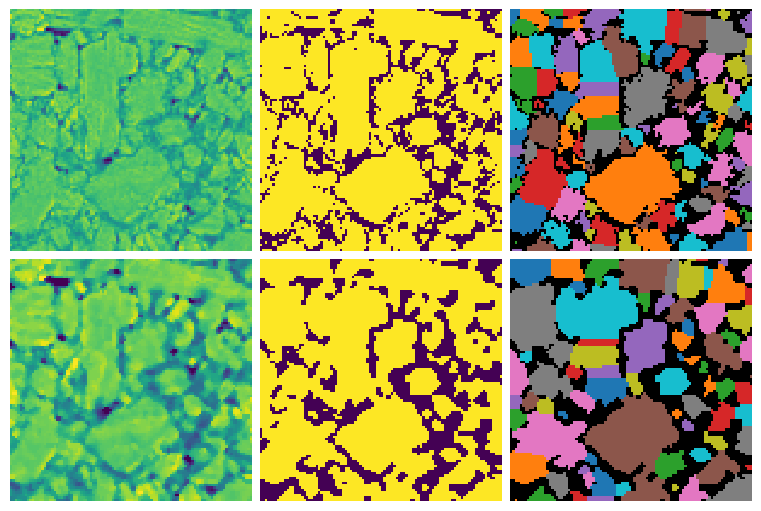

In [8]:
img_labeled_3msd = segment.watershed_segment(img_semantic, min_peak_distance=3)
img_labeled_color_3msd = view.color_labels(img_labeled_3msd, return_image=True)
img_pre_labeled_3msd = segment.watershed_segment(
    img_pre_semantic, min_peak_distance=3)
img_pre_labeled_color_3msd = view.color_labels(
    img_pre_labeled_3msd, return_image=True)
fig, axes = view.images(
    [img_crop, img_semantic, img_labeled_color_3msd,
     img_pre, img_pre_semantic, img_pre_labeled_color_3msd],
    imgs_per_row=3, dpi=100)

Segmenting images...
--> Segmentation complete. 201 particle(s) segmented.
Segmenting images...
--> Segmentation complete. 112 particle(s) segmented.


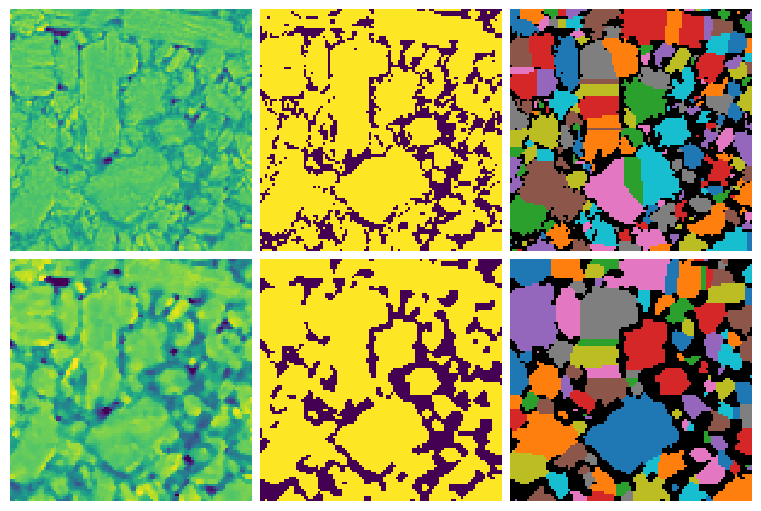

In [9]:
img_labeled_2msd = segment.watershed_segment(img_semantic, min_peak_distance=2)
img_labeled_color_2msd = view.color_labels(img_labeled_2msd, return_image=True)
img_pre_labeled_2msd = segment.watershed_segment(
    img_pre_semantic, min_peak_distance=2)
img_pre_labeled_color_2msd = view.color_labels(
    img_pre_labeled_2msd, return_image=True)
fig, axes = view.images(
    [img_crop, img_semantic, img_labeled_color_2msd,
     img_pre, img_pre_semantic, img_pre_labeled_color_2msd],
    imgs_per_row=3, dpi=100)

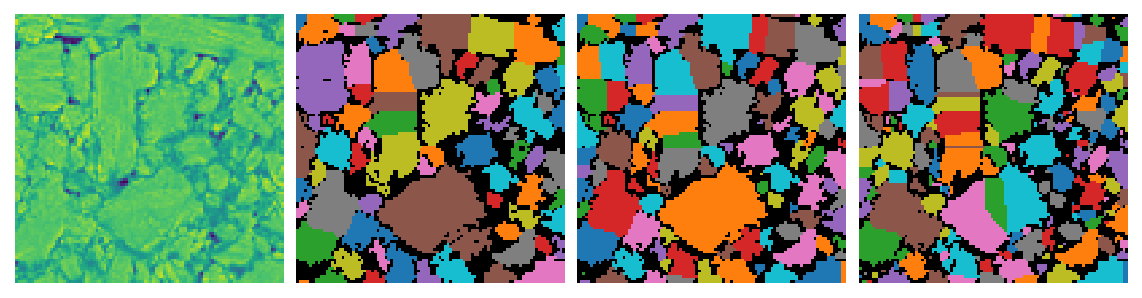

In [13]:
fig, axes = view.images(
    [img_crop, img_labeled_color_4msd, img_labeled_color_3msd,
     img_labeled_color_2msd],
    dpi=150)

## Try ternary semantic segmentation